<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/tpu_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
%%capture
#TPU
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning
!pip install torchmetrics
!pip install onnx
!pip install onnxruntime


In [4]:
import  pytorch_lightning as pl
print(pl.__version__)

1.3.6


In [5]:
!wget http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip

--2021-06-19 19:46:24--  http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11557753157 (11G) [application/zip]
Saving to: ‘CheXpert-v1.0-small.zip’

CheXpert-v1.0-small 100%[===================>]  10.76G  5.20MB/s    in 36m 43s 

2021-06-19 20:23:07 (5.00 MB/s) - ‘CheXpert-v1.0-small.zip’ saved [11557753157/11557753157]



In [6]:
%%capture
!unzip /content/CheXpert-v1.0-small.zip

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
train=pd.read_csv('/content/CheXpert-v1.0-small/train.csv')
train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [9]:
val=pd.read_csv('/content/CheXpert-v1.0-small/valid.csv')
val.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:

import csv
def read_images(path):
  image_names = []
  labels = []
  policy='ones'
  with open(path, "r") as f:
      csvReader = csv.reader(f)
      next(csvReader, None)
      k=0
      for line in csvReader:
          k+=1
          image_name= line[0]
          label = line[5:]
          
          for i in range(14):
              if label[i]:
                  a = float(label[i])
                  if a == 1:
                      label[i] = 1
                  elif a == -1:
                      if policy == "ones":
                          label[i] = 1
                      elif policy == "zeroes":
                          label[i] = 0
                      else:
                          label[i] = 0
                  else:
                      label[i] = 0
              else:
                  label[i] = 0
                  
          image_names.append(image_name)
          labels.append(label)
  return image_names,labels

In [11]:
train_image,train_label=read_images('/content/CheXpert-v1.0-small/train.csv')
val_image,val_label=read_images('/content/CheXpert-v1.0-small/valid.csv')

In [12]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
print(len(class_names))

14


In [13]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from torch.nn.functional import cross_entropy
from sklearn.utils import class_weight
from torchvision import transforms 
import torchvision.models as models
import torchmetrics
import torch#pytorch
from sklearn.utils import class_weight

In [22]:
aug=transforms.Compose([
                        transforms.Resize((224,224)),
                        #transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees=3),
                        #transforms.RandomPerspective(0.05,0.2),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, ], [0.3,]),

                        ])

In [23]:
from PIL import Image
from torch.utils.data import DataLoader, Dataset
class DataReader(Dataset):
  def __init__(self,image,label,transform=None):
    super(DataReader,self).__init__()
    self.image=image
    self.label=label
    self.transform=transform

  def __len__(self):
    return len(self.image)

  def __getitem__(self,index):
    image_path=self.image[index]
    image_label=self.label[index]

    #read data
    image=Image.open(image_path).convert('L')

    if self.transform:
      image=self.transform(image)

    return image,torch.tensor(image_label,dtype=torch.float32)

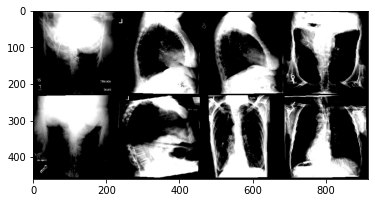

In [24]:
#code testing
from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
train=DataReader(np.array(train_image),np.array(train_label),transform=aug)
train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=8)
batch,_=next(iter(train_loader))
grid_img=torchvision.utils.make_grid(batch,4,4)
plt.imshow(grid_img.permute(1, 2, 0),cmap='gray')

In [25]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from typing import Any, List, Tuple




class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features: int,
        growth_rate: int,
        bn_size: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseLayer, self).__init__()
        self.norm1: nn.BatchNorm2d
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.relu1: nn.ReLU
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.conv1: nn.Conv2d
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.norm2: nn.BatchNorm2d
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.relu2: nn.ReLU
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.conv2: nn.Conv2d
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 1000,
        memory_efficient: bool = False
    ) -> None:

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(1, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
        self.classifier1 = nn.Linear(num_classes, 14)
        self.classifier2=nn.Sigmoid()


        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        out = self.classifier1(out)
        out = self.classifier2(out)
        
        return out





def _densenet(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
   
    **kwargs: Any
) -> DenseNet:
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    return model


def densenet121( **kwargs: Any) -> DenseNet:
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64,
                     **kwargs)

In [26]:
x=torch.randn(1,1,224,224)
model=densenet121()
out=model(x)
out.shape

torch.Size([1, 14])

In [28]:
class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input (after sigmoid layer)
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = x
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()


In [29]:
#criterion=nn.BCEWithLogitsLoss()
criterion=AsymmetricLossOptimized()
criterion(out,torch.tensor(np.expand_dims(train_label[0],0),dtype=torch.float32))


tensor(1.4335, grad_fn=<NegBackward>)

In [20]:
# pred=torch.tensor(np.expand_dims(train_label[0],0),dtype=torch.float32)
# pred.shape,out.shape


In [30]:
train_images=np.array(train_image)
train_labels=np.array(train_label)
val_images=np.array(val_image)
val_labels=np.array(val_label)

In [32]:
import torch.nn as nn
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = densenet121()
   
  #parameters
    
    self.batch_size=64
    self.numworker=1
    #self.criterion=nn.BCELoss()
    self.criterion=AsymmetricLossOptimized()
    
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    optimizer=torch.optim.Adam(params=self.parameters(), lr = 0.0001, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0)
    lr_schedulers ={'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor =0.5,patience =2,verbose =True),
                    'monitor': 'val/loss'}
    return {"optimizer": optimizer, "scheduler": lr_schedulers}

  def train_dataloader(self):
    return DataLoader(DataReader(train_images,train_labels,aug), batch_size = self.batch_size, num_workers=self.numworker,shuffle=True)

  def training_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)

    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    return DataLoader(DataReader(val_images,val_labels,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def validation_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    return loss


  def test_dataloader(self):
    return DataLoader(DataReader(val_images,val_labels,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def test_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    self.log('test/loss', loss, on_epoch=True,prog_bar=True)
    return loss




In [33]:
early_stop_callback = EarlyStopping(monitor='val/loss', min_delta=0.00, patience=2, verbose=True, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val/loss',dirpath='/content/drive/MyDrive/',
                                      filename='chestxraydense' )
model = OurModel()
trainer = Trainer(max_epochs=1, auto_lr_find=False, auto_scale_batch_size=False,
                  tpu_cores=8,precision=16,
                  #gpus=-1,
                  progress_bar_refresh_rate=30, 
                  callbacks=[early_stop_callback,checkpoint_callback]
                  )
#trainer.tune(model)
trainer.fit(model)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores

  | Name      | Type                    | Params
------------------------------------------------------
0 | layer     | DenseNet                | 8.0 M 
1 | criterion | AsymmetricLossOptimized | 0     
------------------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
15.973    Total estimated model params size (MB)


[rank: 1] Metric val/loss improved. New best score: 30.236
[rank: 0] Metric val/loss improved. New best score: 35.249
[rank: 4] Metric val/loss improved. New best score: 30.337
[rank: 6] Metric val/loss improved. New best score: 30.974
[rank: 5] Metric val/loss improved. New best score: 33.208
[rank: 3] Metric val/loss improved. New best score: 35.769
[rank: 7] Metric val/loss improved. New best score: 35.916
[rank: 2] Metric val/loss improved. New best score: 34.839


[rank: 7] Metric val/loss improved by 1.149 >= min_delta = 0.0. New best score: 34.768
[rank: 1] Metric val/loss improved by 0.097 >= min_delta = 0.0. New best score: 30.139
[rank: 0] Metric val/loss improved by 0.651 >= min_delta = 0.0. New best score: 34.599
[rank: 6] Metric val/loss improved by 2.063 >= min_delta = 0.0. New best score: 28.912
[rank: 2] Metric val/loss improved by 0.249 >= min_delta = 0.0. New best score: 34.590
[rank: 5] Metric val/loss improved by 0.467 >= min_delta = 0.0. New best score: 32.741
[rank: 4] Metric val/loss improved by 0.878 >= min_delta = 0.0. New best score: 29.459
[rank: 3] Metric val/loss improved by 0.243 >= min_delta = 0.0. New best score: 35.526


[rank: 2] Metric val/loss improved by 0.390 >= min_delta = 0.0. New best score: 34.199
[rank: 0] Metric val/loss improved by 0.144 >= min_delta = 0.0. New best score: 34.455
[rank: 7] Metric val/loss improved by 0.489 >= min_delta = 0.0. New best score: 34.279
[rank: 3] Metric val/loss improved by 0.349 >= min_delta = 0.0. New best score: 35.177
[rank: 1] Metric val/loss improved by 0.335 >= min_delta = 0.0. New best score: 29.804


[rank: 5] Metric val/loss improved by 1.186 >= min_delta = 0.0. New best score: 31.555
[rank: 3] Metric val/loss improved by 0.407 >= min_delta = 0.0. New best score: 34.770
[rank: 4] Monitored metric val/loss did not improve in the last 2 records. Best score: 29.459. Signaling Trainer to stop.
[rank: 7] Metric val/loss improved by 0.445 >= min_delta = 0.0. New best score: 33.833
[rank: 2] Metric val/loss improved by 0.182 >= min_delta = 0.0. New best score: 34.017
[rank: 6] Monitored metric val/loss did not improve in the last 2 records. Best score: 28.912. Signaling Trainer to stop.
[rank: 1] Metric val/loss improved by 0.465 >= min_delta = 0.0. New best score: 29.340
[rank: 0] Metric val/loss improved by 0.451 >= min_delta = 0.0. New best score: 34.004


[rank: 6] Monitored metric val/loss did not improve in the last 3 records. Best score: 28.912. Signaling Trainer to stop.
[rank: 3] Metric val/loss improved by 0.449 >= min_delta = 0.0. New best score: 34.321
[rank: 5] Metric val/loss improved by 0.183 >= min_delta = 0.0. New best score: 31.372
[rank: 1] Metric val/loss improved by 0.092 >= min_delta = 0.0. New best score: 29.247
[rank: 4] Metric val/loss improved by 0.162 >= min_delta = 0.0. New best score: 29.297


[rank: 2] Monitored metric val/loss did not improve in the last 2 records. Best score: 34.017. Signaling Trainer to stop.
[rank: 6] Monitored metric val/loss did not improve in the last 4 records. Best score: 28.912. Signaling Trainer to stop.
[rank: 3] Metric val/loss improved by 0.376 >= min_delta = 0.0. New best score: 33.945
[rank: 4] Metric val/loss improved by 0.120 >= min_delta = 0.0. New best score: 29.177
[rank: 7] Monitored metric val/loss did not improve in the last 2 records. Best score: 33.833. Signaling Trainer to stop.
[rank: 0] Monitored metric val/loss did not improve in the last 2 records. Best score: 34.004. Signaling Trainer to stop.


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: cleaning up ddp environment...
  warnings.warn(*args, **kwargs)


In [34]:
torch.save(model.state_dict(), '/content/drive/MyDrive/chest_state_dense.pt')

In [35]:
trainer.test(model)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/loss': 34.0}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: cleaning up ddp environment...
  warnings.warn(*args, **kwargs)


[{'test/loss': 34.0}]

In [36]:
test_loader=DataLoader(DataReader(val_images,val_labels,aug), batch_size = 64,num_workers=1,  shuffle=False)
model.eval()
with torch.no_grad():
  preds,labels=[],[]
  for img, lab in test_loader:
    pred=model(img)

    preds.append(pred.detach().numpy())
    labels.append(lab)

In [37]:
preds=np.concatenate(preds)
labels=np.concatenate(labels)

In [38]:
from sklearn import metrics
score=[]
for i in range(14):
    fpr, tpr, threshold = metrics.roc_curve(labels[:,i], preds[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    score.append(roc_auc)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [39]:
all_classes=dict(zip(class_names,score))
print(all_classes)

{'No Finding': 0.15776047261009665, 'Enlarged Cardiomediastinum': 0.7734311926605505, 'Cardiomegaly': 0.7085400425230334, 'Lung Opacity': 0.8472957084068194, 'Lung Lesion': 0.7854077253218884, 'Edema': 0.8389182833627278, 'Consolidation': 0.891301070405548, 'Pneumonia': 0.7771017699115044, 'Atelectasis': 0.839935064935065, 'Pneumothorax': 0.5779867256637168, 'Pleural Effusion': 0.8590580033961926, 'Pleural Other': 0.7510729613733905, 'Fracture': nan, 'Support Devices': 0.7329457649569504}


In [50]:
selected_classes=['Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']
result={k:v for k,v in all_classes.items() if k in selected_classes}
for k,v in result.items():
  print(k,v)
print('mean',np.mean(np.mean(list(result.values()))))

Cardiomegaly 0.7085400425230334
Edema 0.8389182833627278
Consolidation 0.891301070405548
Atelectasis 0.839935064935065
Pleural Effusion 0.8590580033961926
mean 0.8275504929245134


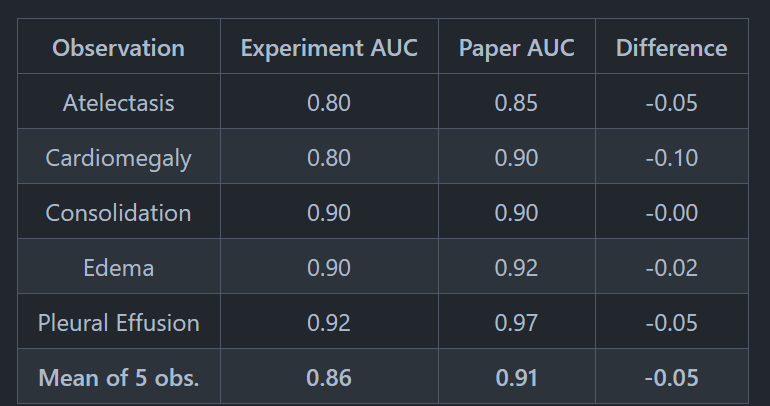

In [41]:
%%capture
!pip install onnx
!pip install onnxruntime

In [42]:
filepath = '/content/drive/MyDrive/chestmodel.onnx'
input_sample = torch.randn((1,1, 224,224))
model.to_onnx(filepath,input_sample, export_params=True)

In [43]:
import onnx
onnx_model = onnx.load(filepath)
onnx.checker.check_model(onnx_model)